In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap
import pickle
import os
import random
import math

## Sklearn

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, label_binarize, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error,log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.stats import skew, kurtosis
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import VarianceThreshold

## Pytorch

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

## Models

In [4]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

# Fix Seeds

In [5]:
#se se utilizar o pytorch
def set_seed(seed=42, deterministic_torch: bool = True):
    random.seed(seed) # Python
    np.random.seed(seed)  # Numpy, é o gerador utilizado pelo sklearn
    os.environ["PYTHONHASHSEED"] = str(seed)  # sistema operativo
    torch.manual_seed(seed)
    torch.set_default_device("cpu")
    if torch is not None:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  #multi-GPU
        if deterministic_torch:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

set_seed()

# Load CSVs

In [6]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Save & Load Data

In [7]:
uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Exploration

## Category Encoder and Decoder

In [8]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [9]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

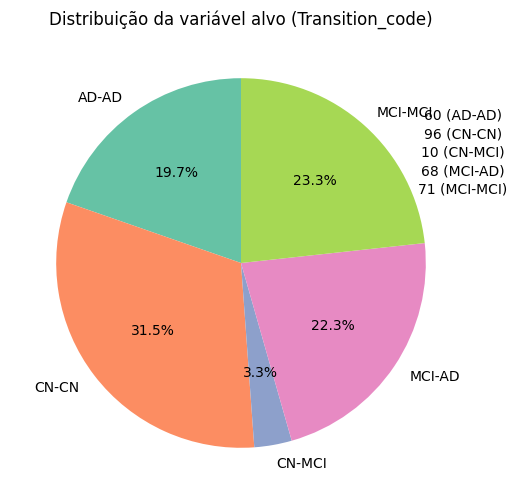

In [10]:
# Obtenção da distribuição e contagem de cada classe
target_distribution = train_df['Transition_code'].value_counts(normalize=True).sort_index()
target_counts = train_df['Transition_code'].value_counts().sort_index()

# Decodificação dos rótulos com o target_encoder
le_make = target_encoder(train_df) 
decoded_labels = le_make.inverse_transform(target_distribution.index)

# Criação do gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(target_distribution.values, labels=decoded_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(target_distribution)))
plt.title("Distribuição da variável alvo (Transition_code)")

# Adicionando as contagens no gráfico
for i, count in enumerate(target_counts):
    plt.text(x=1.2, y=0.8 - i * 0.1, s=f'{target_counts.iloc[i]} ({decoded_labels[i]})', horizontalalignment='center', verticalalignment='center')

plt.show()


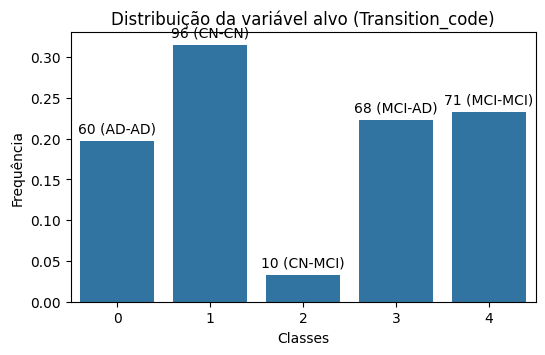

In [11]:
# Obtenção da distribuição e contagem de cada classe
target_distribution = train_df['Transition_code'].value_counts(normalize=True).sort_index()
target_counts = train_df['Transition_code'].value_counts().sort_index()

plt.figure(figsize=(6, 3.5))
ax = sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

le_make = target_encoder(train_df) 
decoded_labels = le_make.inverse_transform(target_distribution.index)

for index, value in enumerate(target_distribution.index):
    ax.text(index, target_distribution[value] + 0.01, f'{target_counts[value]} ({decoded_labels[index]})', ha='center')

plt.show()

## MatPlots

In [12]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [13]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [14]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(14,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [15]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [16]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [17]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code", height=3, aspect=1.5):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue, height=height, aspect=aspect)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [18]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [19]:
def main_exploration(df):
    print(df.shape) 

In [20]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

In [21]:
train_df.describe()

,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition_code
count,305.0,305.000000,305.0,305.000000,305.000000,305.0,305.000000,305.000000,305.000000,305.000000,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,3.0,5.810469,0.0,173.504918,6714.790164,2.0,0.411819,0.096916,10.137707,104.883349,...,0.010477,266015.006289,362.064990,0.002024,0.155767,0.012415,0.002091,0.567213,75.171148,1.980328
std,0.0,0.613858,0.0,24.108871,1066.815670,0.0,0.028993,0.009739,0.911329,6.180335,...,0.002009,59267.210682,102.133366,0.000531,0.024285,0.003814,0.000552,0.496276,6.675866,1.504251
min,3.0,4.321602,0.0,128.000000,3609.000000,2.0,0.330890,0.075142,8.420713,90.675836,...,0.005818,138177.996378,130.618182,0.001137,0.071124,0.002565,0.001168,0.000000,55.300000,0.000000
25%,3.0,5.317298,0.0,157.000000,5941.000000,2.0,0.392944,0.089977,9.525253,100.501871,...,0.009060,225781.559367,285.617369,0.001632,0.140791,0.009751,0.001688,0.000000,71.300000,1.000000
50%,3.0,5.811449,0.0,172.000000,6723.000000,2.0,0.412479,0.096609,10.106838,104.370667,...,0.010580,259226.493061,353.841144,0.001934,0.156580,0.012297,0.001995,1.000000,75.000000,1.000000
75%,3.0,6.237751,0.0,190.000000,7396.000000,2.0,0.431621,0.102240,10.635093,108.677326,...,0.011706,298836.166667,431.288497,0.002305,0.173700,0.015166,0.002373,1.000000,79.900000,3.000000
max,3.0,7.583210,0.0,255.000000,9453.000000,2.0,0.491496,0.144082,14.370911,126.209296,...,0.017015,465865.829238,670.406531,0.004325,0.223273,0.024548,0.004417,1.000000,91.000000,4.000000


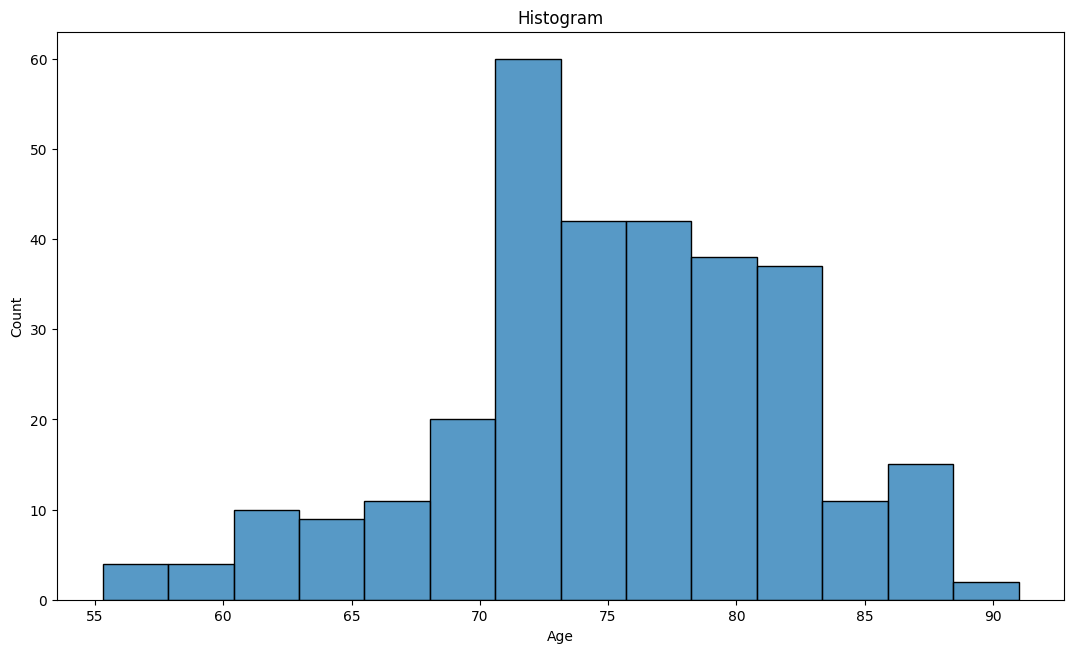

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [22]:
numerical_exploration(train_df)

In [23]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

In [24]:
print(train_df["Sex"].value_counts())

Sex
1    173
0    132
Name: count, dtype: int64


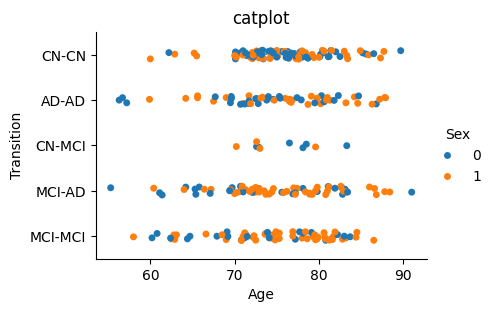

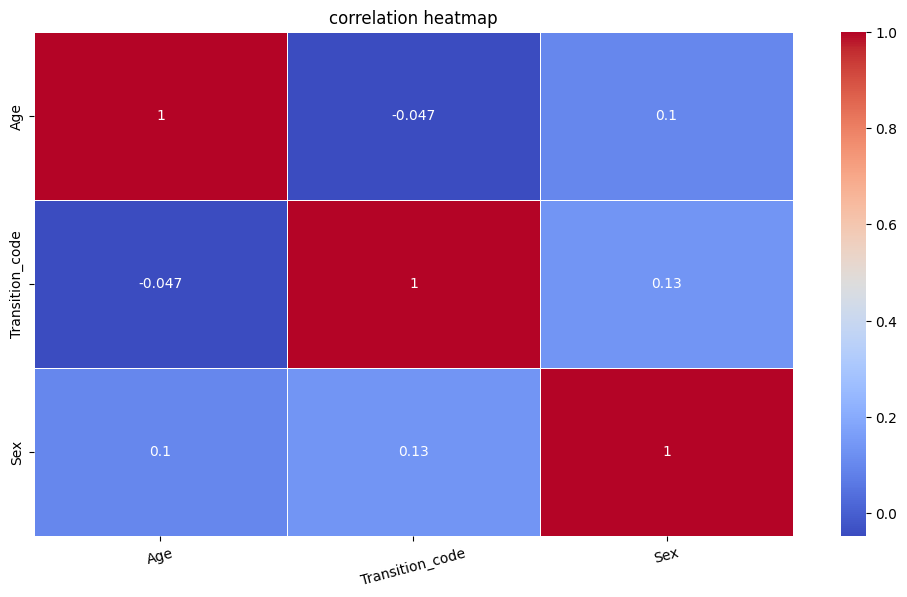

In [25]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

In [26]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [27]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [28]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [29]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [30]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex','diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes']

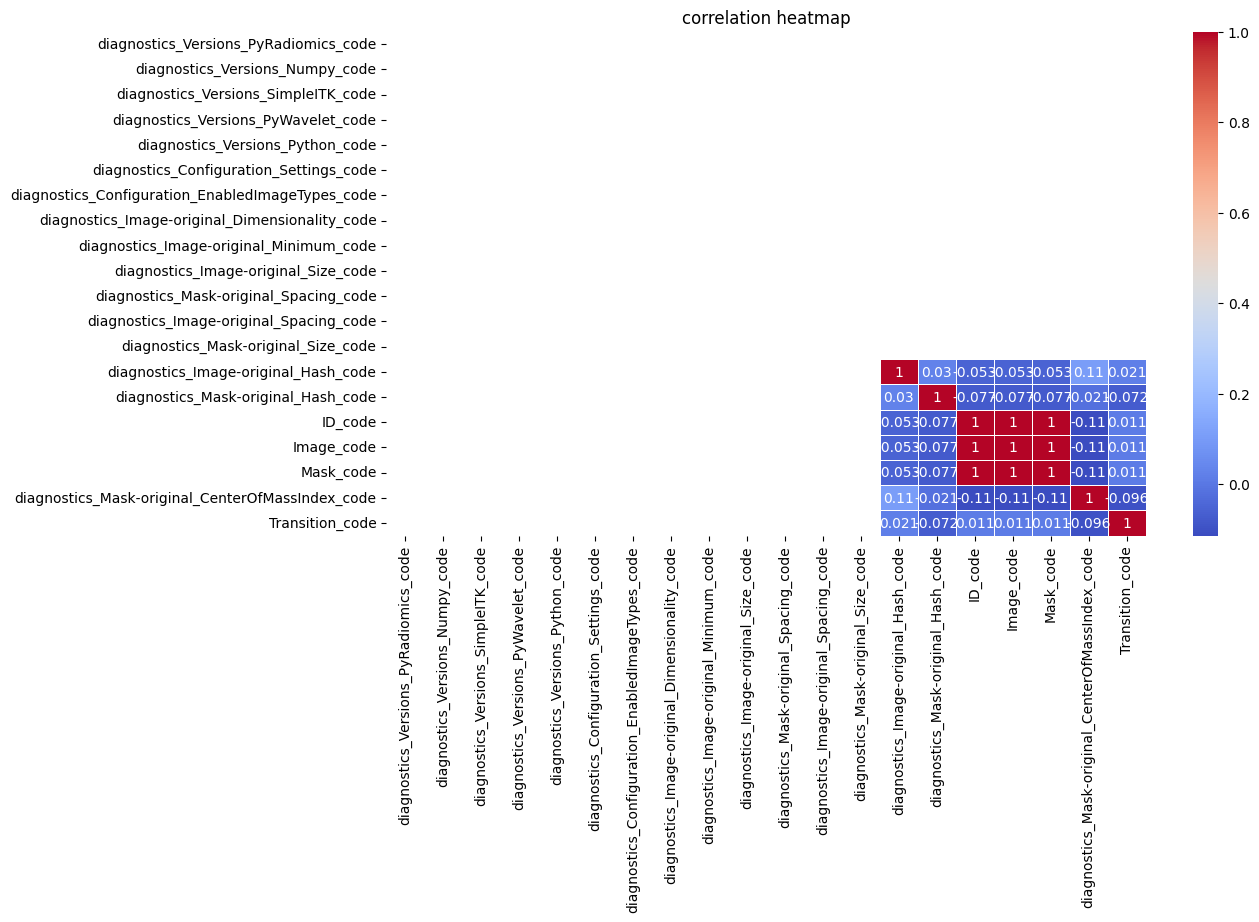

In [31]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

In [32]:
colunas_nao_numericas_train = train_df.select_dtypes(exclude=['number']).columns
colunas_nao_numericas_df = control_df.select_dtypes(exclude=['number']).columns
print(len(colunas_nao_numericas_df))

20


## Correlations

In [33]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target]).abs()

    top_features = corr_matrix.sort_values(ascending=True).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


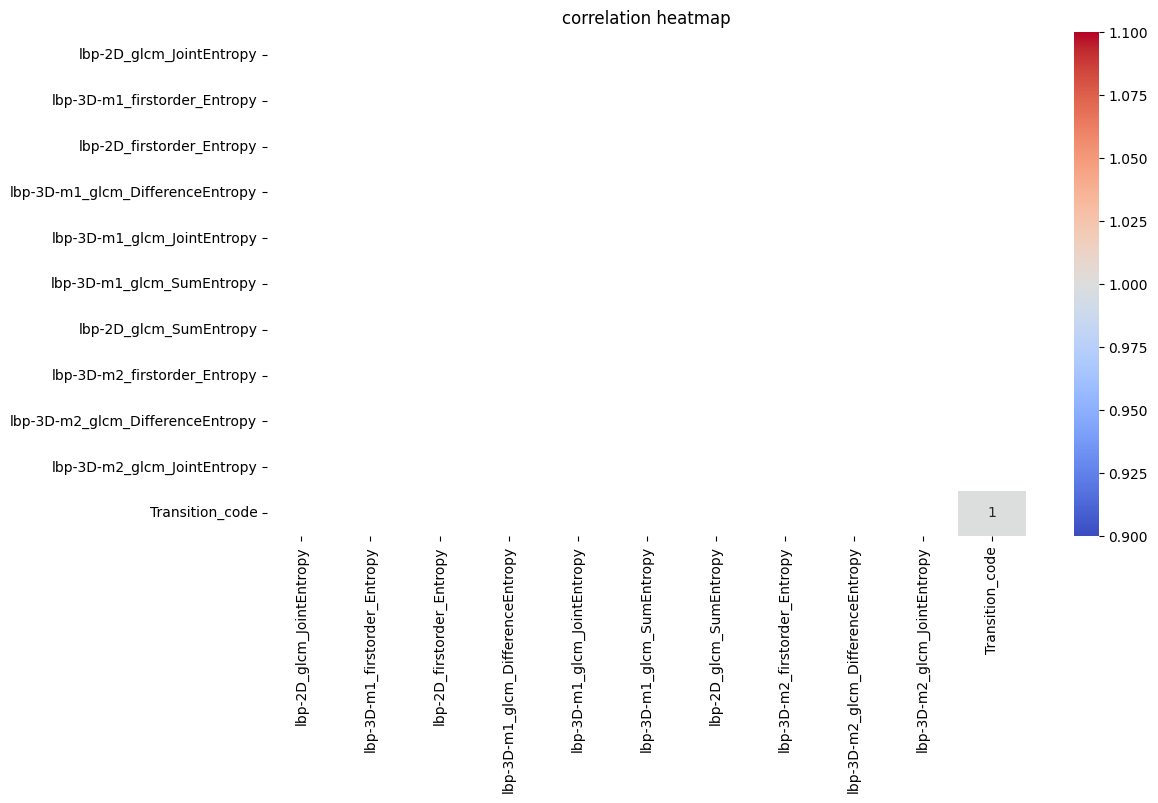

In [34]:
rad_corr = top_correlations(train_df,number=10)
show_heatmap(train_df[rad_corr])

In [35]:
def top_inter_correlations(df, starts_with=None, number=10, ascending=False):
    if starts_with is None:
        corr_columns = df.select_dtypes(include=["int64", "float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]
    
    corr_matrix = df[corr_columns].corr().abs()
    
    mask = ~np.eye(corr_matrix.shape[0], dtype=bool)  # Criar a máscara para ignorar a diagonal
    corr_unstacked = corr_matrix.where(mask).stack()
    
    sorted_corr = corr_unstacked.sort_values(ascending=True)
    top_pairs = sorted_corr.head(number)
    
    top_features = pd.Index(set([x[0] for x in top_pairs.index] + [x[1] for x in top_pairs.index]))
    
    top_corr_matrix = df[top_features].corr()

    # Plotar a matriz de correlação como heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title("Top Correlations Heatmap")
    plt.show()
    
    return top_features

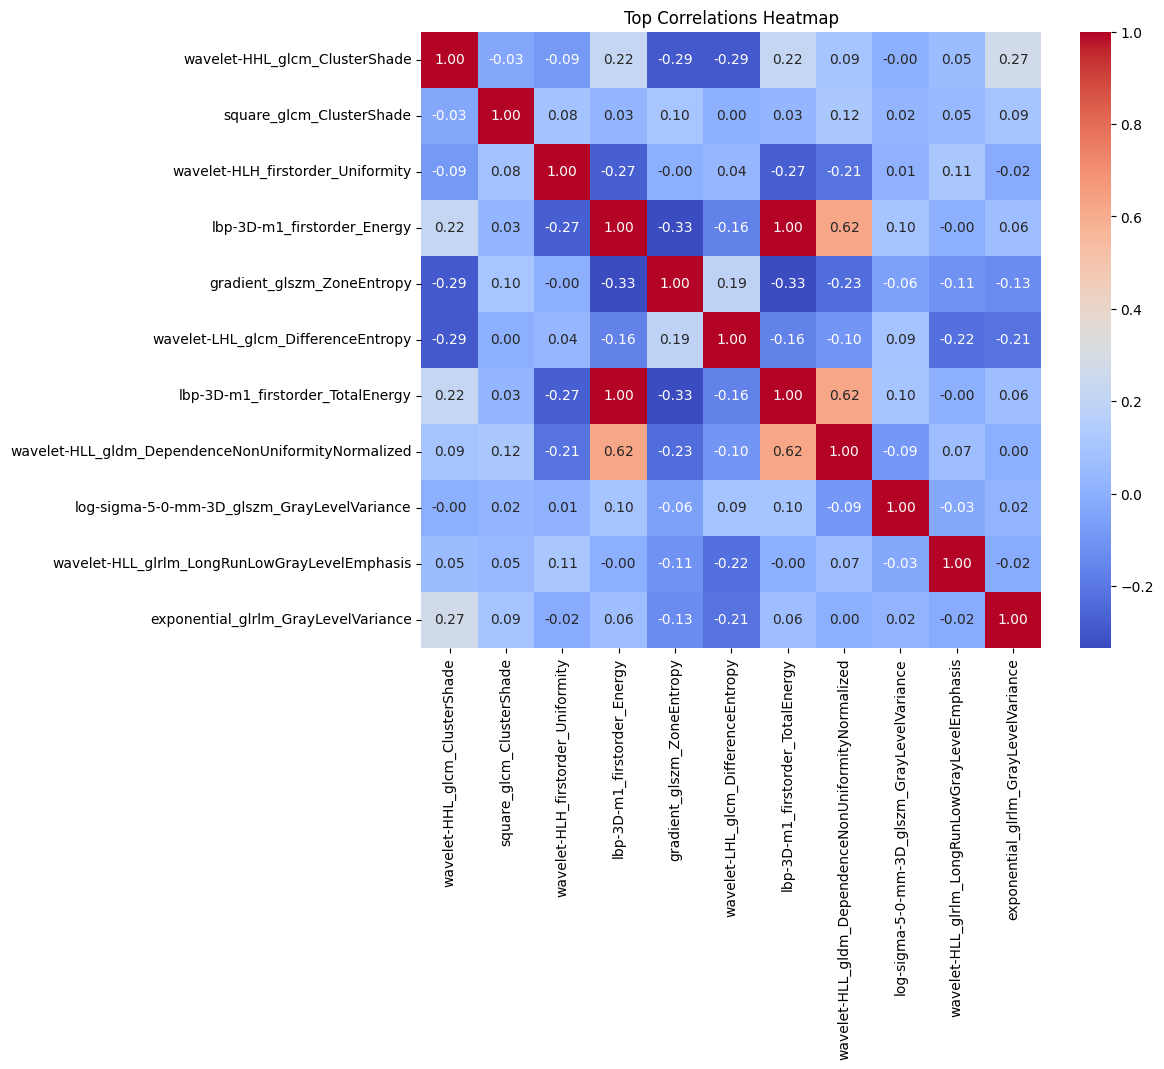

In [36]:
inter_corr = top_inter_correlations(train_df)

# Data Processing

## Drop Unnecessary Columns

In [37]:
print(train_df.shape)
print(control_df.shape)
print(test_df.shape)

(305, 2182)
(305, 2182)
(100, 2180)


In [38]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

In [39]:
def remove_single_value_features(df):
    # Identificar colunas com apenas um valor único
    single_value_columns = df.columns[df.nunique() == 1]
    
    df_cleaned = df.drop(columns=single_value_columns)
    
    return df_cleaned


In [40]:
print(train_df.shape)
print(control_df.shape)
print(test_df.shape)

(305, 2163)
(305, 2163)
(100, 2161)


In [41]:
train_df[['diagnostics_Mask-original_BoundingBox']]


,diagnostics_Mask-original_BoundingBox
0,"(103, 113, 93, 36, 30, 71)"
1,"(81, 127, 93, 47, 16, 73)"
2,"(77, 119, 89, 49, 30, 81)"
3,"(93, 102, 90, 41, 29, 78)"
4,"(87, 119, 91, 40, 27, 75)"
...,...
300,"(88, 118, 89, 41, 25, 78)"
301,"(103, 103, 93, 38, 27, 70)"
302,"(80, 131, 89, 48, 17, 82)"
303,"(93, 103, 91, 40, 31, 75)"


## Non Numerical Columns

In [42]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [43]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [44]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [45]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [46]:
main_exploration(train_df)

(305, 2170)


In [47]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

In [48]:
main_exploration(train_df)

(305, 2169)


## Data Scaler

In [49]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [50]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

scaled_train_df.shape

(305, 2169)

## Correlation Analisys

In [51]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [52]:
corr_threshold_target = 0.005
corr_threshold_features = 0.9

def apply_correlation(df, threshold_target, threshold_features):
    # Remove a coluna "Transition" se existir
    df = df.drop(columns=["Transition"], errors="ignore")
    
    # Calcula a correlação com o target
    correlation_with_target = df.corr()[target].abs()
    important_features = correlation_with_target[correlation_with_target > threshold_target].index.tolist()
    
    if target in important_features:
        important_features.remove(target)
    
    # Remove features que são muito correlacionadas entre si
    correlation_matrix = df[important_features].corr().abs()
    selected_features = important_features.copy()
    
    for i, feature in enumerate(important_features):
        for other_feature in important_features[i+1:]:
            if correlation_matrix.loc[feature, other_feature] > threshold_features:
                if other_feature in selected_features:
                    selected_features.remove(other_feature)
    
    return selected_features


In [53]:
important_features = apply_correlation(scaled_train_df, corr_threshold_target, corr_threshold_features)
print(len(important_features))

655


In [54]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]
corr_train_df.shape

(305, 655)

In [55]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

/var/folders/mw/3tkw6q2j7wn1mq2731n0bv_40000gn/T/ipykernel_26857/3502452529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_train_df["Transition_code"] = train_df["Transition_code"].values
/var/folders/mw/3tkw6q2j7wn1mq2731n0bv_40000gn/T/ipykernel_26857/3502452529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_control_df["Transition_code"] = train_df["Transition_code"].values


In [56]:
corr_train_df.to_csv("../Dataset/train_radiomics_hipocamp_processed.csv",index=False)
corr_control_df.to_csv("../Dataset/train_radiomics_occipital_CONTROL_processed.csv",index=False)
corr_test_df.to_csv("../Dataset/test_radiomics_hipocamp_processed.csv",index=False)

In [57]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 656)
(305, 656)
(100, 655)


# Testing Phase

In [58]:
def define_X_y(train_df, test_df = pd.DataFrame(),random_state=42):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [59]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

(244, 655)
(61, 655)


## Params

In [60]:
total_samples = len(x_train)

class_counts = np.bincount(y_train)

scale_pos_weight = total_samples / class_counts

weights = {i:w for i,w in enumerate(scale_pos_weight)}

sample_class_weights = {i: total_samples / count for i,count in enumerate(class_counts)}
sample_weights = np.array([sample_class_weights[label] for label in y_train])

ann_class_weights = torch.tensor(scale_pos_weight, dtype=torch.float)


### Grid Params

In [61]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}


param_grid_xgb = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'min_child_weight': [3, 5],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

param_grid_light = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'num_leaves': [31, 50],
    'max_depth': [5, 10],
    'objective': ['multiclassova'],
    'subsample': [0.7,  0.9],
    'colsample_bytree': [0.7, 0.9],
    'lambda_l1': [0.1, 0.5],
    'lambda_l2': [0.1, 0.5],
}


param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4, 5]
}

param_grid_log = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 500]
}

### Bayes Params

In [62]:
param_baye_rf = {
    'n_estimators': (100, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': (0, 1),
    'class_weight': (0, 1),
}


param_baye_xgb = {
    'learning_rate': (0.01, 0.15),
    'n_estimators': (100, 300),
    'max_depth': (5, 20),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'min_child_weight': (1, 15),
}

param_baye_light = {
    'learning_rate': (0.01, 0.2),
    'num_leaves': (20, 50),
    'max_depth': (5, 15),
    'min_data_in_leaf': (10, 30),
    'bagging_fraction': (0.5, 1.0)
}


param_baye_svm = {
    'C': (1, 100),
    'gamma': (0.01, 1),
    'kernel': (0, 1),
    'class_weight': (0, 1),
    'degree': (2, 4),
    'tol': (1e-4, 1e-3)
}

param_baye_log = {
    'C': (0.01, 10),
    'max_iter': (300, 1500),
    'solver': (0,2)  # Selecione os solvers compatíveis com os dados.
}

## Models

### RandomForest

In [63]:
# Basic Model
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def random_forest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(model, param_grid_rf, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

#Bayes Model
def objective_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf,bootstrap,class_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bool(round(bootstrap)),
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

def random_forest_baye_model(x_train,y_train, param_baye=param_baye_rf):
    rf_bo = BayesianOptimization(
        f=objective_random_forest,
        pbounds=param_baye,
        random_state=42,
    )
    
    rf_bo.maximize(init_points=7, n_iter=25)

    best_params = rf_bo.max['params']
    bootstrap = bool(round(best_params["bootstrap"]))
    best_params_updated = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'min_samples_split': int(best_params['min_samples_split']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'bootstrap': bootstrap,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'random_state': 42
    }

    print(best_params_updated)

    model = RandomForestClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    rf_results = pd.DataFrame(rf_bo.res)
    rf_results.sort_values(by="target",ascending=False,inplace=True)

    return model, rf_results, rf_bo.max

### SVM

In [64]:
def svm_train_model(x_train,y_train):
    model = SVC(random_state=42,class_weight="balanced", probability=True,decision_function_shape='ovo')
    model.fit(x_train,y_train)

    return model

# Grid Model
def svm_grid_train_model(x_train,y_train, param_grid=param_grid_svm):
    model = SVC(random_state=42,decision_function_shape='ovo',class_weight="balanced",probability=True)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

def objective_svm(C, gamma, kernel, class_weight, degree, tol):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    
    params = {
        'C': C,
        'gamma': 'scale' if round(gamma) == 0 else gamma,  # 'scale' ou um valor float de gamma
        'kernel': 'linear' if round(kernel) == 0 else 'rbf',  # 'linear' ou 'rbf'
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'degree': int(degree) if round(kernel) == 1 else 3,  # Degree apenas para kernel polinomial
        'tol': tol,
        'random_state': 42
    }
    
    model = SVC(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy').mean()  # Troque "scorer" por "accuracy"
    return score

def svm_baye_train_model(x_train, y_train, param_baye=param_baye_svm):
    svm_bo = BayesianOptimization(
        f=objective_svm,
        pbounds=param_baye,
        random_state=42,
    )
    
    svm_bo.maximize(init_points=7, n_iter=25)

    best_params = svm_bo.max['params']

    gamma = 'scale' if round(best_params["gamma"]) == 0 else best_params["gamma"]
    kernel = 'linear' if round(best_params["kernel"]) == 0 else 'rbf'
    best_params_updated = {
        'C': best_params['C'],
        'gamma': gamma,
        'kernel': kernel,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'degree': int(best_params['degree']) if kernel == 'rbf' else 3,  # Degree só para kernel 'rbf'
        'tol': best_params['tol'],
        'random_state': 42
    }

    print(best_params_updated)

    model = SVC(**best_params_updated)
    model.fit(x_train, y_train)

    svm_results = pd.DataFrame(svm_bo.res)
    svm_results.sort_values(by="target", ascending=False, inplace=True)

    return model, svm_results, svm_bo.max

### XGBoost

In [65]:
# Basic Model
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=42,objective='multi:softprob')
    model.fit(x_train,y_train, sample_weight=sample_weights)

    return model

# Grid Model
def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=42,objective='multi:softprob')
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(model, param_grid_xgb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)
    

    return grid_search.best_estimator_

# Baye Model
def objective_xgboost(learning_rate, n_estimators, max_depth, subsample, colsample_bytree,min_child_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score
    
def xgboost_baye_model(x_train,y_train, param_baye=param_baye_xgb):
    xgb_bo = BayesianOptimization(
    f=objective_xgboost,
    pbounds=param_baye,
    random_state=42,
    )
    
    xgb_bo.maximize(init_points=7, n_iter=25)

    best_params = xgb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']), 
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'random_state': 42
    }

    print(best_params_updated)
    
    model = XGBClassifier(**best_params_updated)
    model.fit(x_train,y_train, sample_weight=sample_weights)

    xgb_results = pd.DataFrame(xgb_bo.res)
    xgb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, xgb_results, xgb_bo.max

### LightGBM

In [66]:
# Basic Model
def light_boost_model(x_train,y_train):
    model =  lgb.LGBMClassifier(verbose=-1,objective='multiclassova',class_weight=weights)
    model.fit(x_train,y_train)

    return model

# Grid Model
def light_grid_train_model(x_train,y_train, param_grid=param_grid_light):
    model = lgb.LGBMClassifier(verbose=-1,random_state=42,class_weight=weights)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(model, param_grid_light, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Bayes Model
def objective_light_boost(learning_rate, num_leaves, max_depth, min_data_in_leaf, bagging_fraction):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'bagging_fraction': bagging_fraction,
        'boosting_type': 'gbdt',
        'objective': 'multiclassova', 
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 42,
        'class_weight': weights,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def light_baye_train_model(x_train, y_train, param_baye=param_baye_light):
    light_bo = BayesianOptimization(
        f=objective_light_boost,
        pbounds=param_baye,
        random_state=42,
    )
    
    light_bo.maximize(init_points=7, n_iter=20)

    best_params = light_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'bagging_fraction': best_params['bagging_fraction'],
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }

    print(best_params_updated)
    
    model = lgb.LGBMClassifier(**best_params_updated)
    model.fit(x_train, y_train)

    light_results = pd.DataFrame(light_bo.res)
    light_results.sort_values(by="target", ascending=False, inplace=True)

    return model, light_results, light_bo.max

### Logistic Regression

In [67]:
# Basic Model
def log_reg_model(x_train,y_train):
    model = LogisticRegression(max_iter=1000,random_state=42,class_weight='balanced')
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def log_grid_train_model(x_train,y_train, param_grid=param_grid_log):
    model = LogisticRegression(random_state=42, verbose=0,class_weight='balanced')
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Função de objetivo para otimização bayesiana
def objective_logistic_regression(C, max_iter, solver):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

    solvers = ['lbfgs', 'liblinear', 'saga']
    solver = solvers[int(round(solver))]  # Converte o índice numérico de volta para string


    params = {
        'C': C,
        'max_iter': int(max_iter),
        'solver': solver,
        'random_state': 42,
        'verbose': 0
    }

    model = LogisticRegression(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

# Função principal para regressão logística com BayesOpt
def log_baye_train_model(x_train, y_train, param_baye=param_baye_log):
    log_bo = BayesianOptimization(
        f=objective_logistic_regression,
        pbounds=param_baye,
        random_state=42,
    )
    
    log_bo.maximize(init_points=5, n_iter=25)

    best_params = log_bo.max['params']

    solvers = ['lbfgs', 'liblinear', 'saga']
    best_solver = solvers[int(round(best_params['solver']))]  

    best_params_updated = {
        'C': best_params['C'],
        'max_iter': int(best_params['max_iter']),
        'solver': best_solver,  
        'random_state': 42,
        'verbose': 0
    }

    print(best_params_updated)

    model = LogisticRegression(**best_params_updated)
    model.fit(x_train, y_train)

    # Criar DataFrame com resultados da otimização
    log_results = pd.DataFrame(log_bo.res)
    log_results.sort_values(by="target", ascending=False, inplace=True)

    return model, log_results, log_bo.max

### GradientBoost

In [68]:
# Basic Model
def gradient_boost_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=42)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def gradient_grid_model(x_train,y_train, param_grid_gb):
    model = GradientBoostingClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_


# Baye Model
def objective_gradient_boost(learning_rate, n_estimators, max_depth, subsample,min_samples_split,min_samples_leaf):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 42
    }
    
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def gradient_baye_model(x_train,y_train, param_baye):
    gb_bo = BayesianOptimization(
        f=objective_gradient_boost,
        pbounds=param_baye,
        random_state=42,
    )
    
    gb_bo.maximize(init_points=7, n_iter=70)

    best_params = gb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),  
        'subsample': best_params['subsample'],
        'min_samples_split': int(best_params['min_samples_split']), 
        'min_samples_leaf': int(best_params['min_samples_leaf']), 
        'random_state': 42 
    }

    print(best_params_updated)
    
    model = GradientBoostingClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    gb_results = pd.DataFrame(gb_bo.res)
    gb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, gb_results, gb_bo.max

### CatBoosting

In [69]:
# Basic Model
def cat_boost_model(x_train,y_train):
    model = CatBoostClassifier(verbose=False, task_type="GPU")
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_cat_boost(learning_rate, iterations, depth, l2_leaf_reg, border_count):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'iterations': int(iterations),
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': int(border_count),
        'task_type': 'GPU',
        'random_seed': 42,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def cat_baye_model(x_train, y_train, param_baye):
    cat_bo = BayesianOptimization(
        f=objective_cat_boost,
        pbounds=param_baye,
        random_state=42,
    )
    
    cat_bo.maximize(init_points=5, n_iter=20)


    best_params = cat_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'iterations': int(best_params['iterations']),
        'depth': int(best_params['depth']),
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': int(best_params['border_count']),
        'task_type': 'GPU',
        'random_seed': 42,
        'verbose': 0
    }

    print(best_params_updated)
    

    model = CatBoostClassifier(**best_params_updated)
    model.fit(x_train, y_train)


    cat_results = pd.DataFrame(cat_bo.res)
    cat_results.sort_values(by="target", ascending=False, inplace=True)

    return model, cat_results, cat_bo.max

### Voting Ensemble

In [70]:
def voting_ensemble(x_train,y_train,estimators):
    model = VotingClassifier(estimators=estimators, voting="hard")
    model.fit(x_train,y_train)
    
    return model

### Stacking Ensemble

In [71]:
def stacking_ensemble(x_train,y_train,rf_model,xgb_model,light_model,svm_model,log_model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    estimators = [
        ("rf",RandomForestClassifier(**rf_model.get_params())),
        ("xgb",XGBClassifier(**xgb_model.get_params())),
        ("light",lgb.LGBMClassifier(**light_model.get_params())),
        ("svm",SVC(**svm_model.get_params())),
        ("log",LogisticRegression(**log_model.get_params())),
          
    ]
    
    model = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(class_weight="balanced",n_jobs=-1,max_iter=3000,verbose=0,random_state=42), 
        cv=cv, 
        n_jobs=-1,
    )
    
    model.fit(x_train,y_train)
    
    return model

def grid_stacking_ensemble(x_train,y_train,rf_model,xgb_model,light_model,svm_model,log_model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    estimators = [
        ("rf",RandomForestClassifier(**rf_model.get_params())),
        ("xgb",XGBClassifier(**xgb_model.get_params())),
        ("light",lgb.LGBMClassifier(**light_model.get_params())),
        ("svm",SVC(**svm_model.get_params())),
        ("log",LogisticRegression(**log_model.get_params())),
          
    ]

    meta_learner = LogisticRegression(solver='liblinear', random_state=42)

    stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_learner)

    param_grid = {
        'final_estimator__C': [0.01, 0.1, 1, 10],  # Regularização
        'final_estimator__penalty': ['l2'],  # Penalização L2
        'final_estimator__solver': ['liblinear', 'saga'],  # Solvers para regressão logística
        'final_estimator__max_iter': [100, 200, 500]  # Número de iterações
    }

    grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)

    grid_search.fit(x_train, y_train)

    return grid_search.best_estimator_

### Neural Networks

In [72]:
def tensor_converter(x_train, x_test, y_train, y_test):
    if not isinstance(x_train, np.ndarray):
        # Converter para np array
        x_train = x_train.values  
        y_train = y_train.values  
    
        x_test = x_test.values
        y_test = y_test.values

    
    # Convertendo os dados para tensores
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Usando long para labels inteiros
    
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Criando DataLoader
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader,test_loader

In [73]:
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.log_softmax(self.fc3(x))
        return x

In [74]:
def train_model(train_loader,ann_model,criterion,optimizer):
    epochs = 20 

    for epoch in range(epochs):
        ann_model.train()
        running_loss = 0.0
    
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zera os gradientes
            outputs = ann_model(inputs)  # Passa os inputs pelo modelo
            loss = criterion(outputs, labels)  # Calcula a perda
            loss.backward() 
            optimizer.step()  # Atualiza os pesos
    
            running_loss += loss.item()

In [75]:
def model_evaluate(test_loader,ann_model):
    ann_model.eval()  # Coloca o modelo em modo de avaliação
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # Desativa o cálculo de gradientes para otimização de memória
        for inputs, labels in test_loader:
            outputs = ann_model(inputs)
            _, predicted = torch.max(outputs, 1)  # Obtém a previsão (classe com maior probabilidade)
            all_labels.extend(labels.cpu().numpy())  # Coleta as labels reais
            all_predictions.extend(predicted.cpu().numpy())  # Coleta as previsões
    
    # Calcula o F1 Macro Score
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    return f1_macro

In [76]:
def ann_init(x_train, x_test, y_train, y_test):
    train_loader, test_loader = tensor_converter(x_train, x_test, y_train, y_test)
    
    input_size = x_train.shape[1]  
    hidden_size = 64  # Tamanho da camada oculta
    output_size = 5
    
    ann_model = ANNModel(input_size, hidden_size, output_size)
    
    criterion = nn.CrossEntropyLoss(weight=ann_class_weights)  # Para problemas de classificação multiclasse
    optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    train_model(train_loader,ann_model,criterion,optimizer)
    
    return model_evaluate(test_loader,ann_model)

In [77]:
def ann_cross_valid(x_train,y_train):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    f1_scores=[]
    
    for train_idx, val_idx in cv.split(x_train, y_train):
        X_train, X_val = x_train[train_idx], x_train[val_idx]
        Y_train, Y_val = y_train[train_idx], y_train[val_idx]

        f1_scores.append(ann_init(X_train,X_val,Y_train,Y_val))

    return f1_scores
            

## Models Applier

In [78]:
def apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=4, title="Models Macro F1 Comparison", rf=1, xgb=1, gradient=0, cat=0, log=1, light=1,svm=1):
        
    if rf:
        rf_model = random_forest_model(x_train,y_train)
        results["RandomForest"] = [rf_model,None]
    else:
        rf_model = None

    if xgb:
        xgb_model = xgboost_model(x_train,y_train)
        results["XGBoost"] = [xgb_model,None]
    else:
        xgb_model = None
        
    if gradient:
        gradient_model = gradient_boost_model(x_train,y_train)
        results["GradientBoost"] = [gradient_model,None]
    else:
        gradient_model = None
        
    if cat:
        cat_model = cat_boost_model(x_train,y_train)
        results["CatBoost"] = [cat_model,None]
    else:
        cat_model = None
        
    if log:
        log_model = log_reg_model(x_train,y_train)
        results["Logistic"] = [log_model,None]
    else:
        log_model = None      

    if light:
        light_model = light_boost_model(x_train,y_train)
        results["LightGBM"] = [light_model,None]
    else:
        light_model = None  

    if svm:
        svm_model = svm_train_model(x_train,y_train)
        results["SVM"] = [svm_model,None]
    else:
        svm_model = None 
        
    models_comparison(results,title,x_train=x_train,y_train=y_train)

    return rf_model, xgb_model, gradient_model, cat_model, log_model, light_model, svm_model

## Models Comparison

In [79]:
def models_comparison(results, title, x_train, y_train,colorido=0):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # OneHotEncoder para converter os valores reais de y_train em one-hot
    encoder = OneHotEncoder(sparse_output=False)
    y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))

    for result in results:
        if result == "ANNModel" and results[result][1] is None:
            f1_scores = ann_cross_valid(x_train,y_train)
            mean = np.mean(f1_scores)
            std = np.std(f1_scores)
            results[result] = [None,mean]
            
            print(f"F1 Macro Score em {result}: {mean} -> {std}")
            
        elif results[result][1] is None:
            predictions = []
            true_values = []
            f1_scores = []

            for train_idx, val_idx in cv.split(x_train, y_train):
                X_train, X_val = x_train[train_idx], x_train[val_idx]
                Y_train, Y_val = y_train[train_idx], y_train[val_idx]
                Y_val_one_hot = y_train_one_hot[val_idx]

                model = results[result][0]
                model.fit(X_train, Y_train)
                y_pred_prob = model.predict_proba(X_val)  # Probabilidades das classes
                y_pred = np.argmax(y_pred_prob, axis=1)  # A classe com maior probabilidade

                predictions.append(y_pred_prob)
                true_values.append(Y_val_one_hot)

                # F1 Score«
                f1 = f1_score(Y_val, y_pred, average='macro')
                f1_scores.append(f1)

            predictions = np.concatenate(predictions)
            true_values = np.concatenate(true_values)

            # Bias^2«
            avg_predictions = predictions.mean(axis=0)  # Média das probabilidades por classe
            bias_squared = np.mean(np.sum((avg_predictions - true_values) ** 2, axis=1))  # Erro médio quadrático entre as probabilidades médias e os valores reais

            # Variance«
            variance = np.mean(np.var(predictions, axis=0))  # Variância das probabilidades de previsão

            # Total Error«
            total_error = log_loss(true_values, predictions)  # Erro logarítmico total entre as probabilidades preditas e os valores reais

            # Noise (Ruído)
            noise = total_error - (bias_squared + variance)  # Ruído é a diferença entre o erro total e a soma de bias e variância

            f1_macro_avg = np.mean(f1_scores)

            results[result][1] = round(f1_macro_avg, 4)

            print(f"F1 Macro Score em {result}: {results[result][1]} -> bias: {round(bias_squared, 3)} variance: {round(variance, 3)} ruído: {round(noise, 3)}")

        else:
            print(f"F1 Macro Score em {result}: {results[result][1]}")

    # Criar gráfico
    models_score = plt.figure(figsize=(6, 3))
    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])

    # Alternar cores com base no índice
    if colorido == 1:
        colors = ['red' if i % 2 == 0 else 'green' for i in range(len(mod))]
    else: 
        colors = "lightblue"
    plt.bar(mod, f1, color=colors, width=0.5)
    plt.xlabel("Modelo")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## MultiClass Analysis

In [80]:
def class_accuracy(model,x_test,y_test):
    conf_matrix = confusion_matrix(y_test, model.predict(x_test))
    # grafico de barras com a percentagem de acertos
    class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    class_accuracies_percentage = class_accuracies * 100  
    total_per_class = np.sum(conf_matrix, axis=1) 
    correct_per_class = np.diag(conf_matrix) 
    
    plt.figure(figsize=(7, 4))
    classes = np.unique(y_test)
    plt.bar(classes, class_accuracies_percentage, color='skyblue', alpha=0.8)
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Class")
    plt.ylim(0, 100) 
    

    for i, v in enumerate(class_accuracies_percentage):
        text = f"{correct_per_class[i]}/{total_per_class[i]} ({v:.1f}%)"
        plt.text(classes[i], v + 2, text, ha='center', fontsize=10)
    
    plt.show()
    
    # matriz de confusão
    
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predict")
    plt.ylabel("Real Values")
    plt.title("Confusion Matrix")
    plt.show()

## ROC & AUC Analysis

In [81]:
def roc_auc(model, X_test, y_test):
    # Binariza o target para multiclasse
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    n_classes = y_test_bin.shape[1]

    # Prepara o gráfico
    plt.figure(figsize=(6, 5))
    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Cores para cada classe

    for classe in range(n_classes):
        # Calcula as pontuações preditas para o modelo
        y_score = model.predict_proba(X_test)
        
        # Calcula a curva ROC e a AUC para a classe atual
        fpr, tpr, _ = roc_curve(y_test_bin[:, classe], y_score[:, classe])
        auc = roc_auc_score(y_test_bin[:, classe], y_score[:, classe])
        
        # Plota a curva ROC para a classe atual
        plt.plot(fpr, tpr, color=colors[classe], label=f'Classe {classe} (AUC = {auc:.2f})')

    # Linha de referência (modelo aleatório)
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
    plt.title('Curvas ROC por Classe (One-vs-Rest)')
    plt.xlabel('Falsos Positivos (FPR)')
    plt.ylabel('Verdadeiros Positivos (TPR)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

## Final Predict

In [82]:
def final_score(model,x_test,y_test,plot=1):
    predictions = []
    true_values = []
    f1_scores = []

    x_test_1 = np.array(x_test)
    y_test_1 = np.array(y_test)

    encoder = OneHotEncoder(sparse_output=False)
    y_test_one_hot = encoder.fit_transform(y_test_1.reshape(-1, 1))
    
    y_pred_prob = model.predict_proba(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    true_values.append(y_test_one_hot)
    predictions.append(y_pred_prob)

    f1 = f1_score(y_test, y_pred, average='macro')

    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)

    # Bias^2 (usando probabilidades)
    avg_predictions = predictions.mean(axis=0)  # Média das probabilidades por classe
    bias_squared = np.mean(np.sum((avg_predictions - true_values) ** 2, axis=1))  # Erro médio quadrático entre as probabilidades médias e os valores reais

    # Variance (variância das previsões por classe)
    variance = np.mean(np.var(predictions, axis=0))  # Variância das probabilidades de previsão

    # Total Error (usando log loss)
    total_error = log_loss(true_values, predictions)  # Erro logarítmico total entre as probabilidades preditas e os valores reais

    # Noise (Ruído)
    noise = total_error - (bias_squared + variance)  # Ruído é a diferença entre o erro total e a soma de bias e variância

    print(f"F1 Macro Score: {round(f1, 4)}\nBias: {round(bias_squared, 3)}\nVariance: {round(variance, 3)}\nRuído: {round(noise, 3)}")

    if plot==1:
        roc_auc(model, x_test, y_test)
        class_accuracy(model, x_test, y_test) 

    return f1

def plot_final_scores(test_results):
    keys = list(test_results.keys())
    values = list(test_results.values())

    plt.plot(keys, values, marker='o', linestyle='', color='green')
    plt.xlabel('Número de Features')
    plt.ylabel('Score')
    plt.grid()
    plt.show()

# Models Tester

In [83]:
rf_model,xgb_model,gradient_model,cat_model, log_model,light_model, svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=3)

results["ANNModel"] = [None,None]
models_comparison(results, "WithANN", x_train, y_train)

F1 Macro Score em RandomForest: 0.3512 -> bias: 0.757 variance: 0.016 ruído: 0.487
F1 Macro Score em XGBoost: 0.3242 -> bias: 0.761 variance: 0.07000000029802322 ruído: 0.799
F1 Macro Score em Logistic: 0.3408 -> bias: 0.759 variance: 0.097 ruído: 1.566


KeyboardInterrupt: 

## Bayesian Optimization

In [ ]:
results = {}

rf_baye_model, rf_baye_results, best_params = random_forest_baye_model(x_train,y_train)
results["RandomForestBaye"] = [rf_baye_model,None]
bayes_visualization(param_baye_rf, rf_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

xgb_baye_model, xgb_baye_results, best_params = xgboost_baye_model(x_train,y_train)
results["XGBoostBaye"] = [xgb_baye_model,None]
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

light_baye_model, light_baye_results, best_params = light_baye_train_model(x_train,y_train)
results["LightBoostBaye"] = [light_baye_model,None]
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)


log_baye_model, log_baye_results, best_params = log_baye_train_model(x_train,y_train)
results["LogBaye"] = [log_baye_model,None]
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

In [ ]:
save_stuff(rf_baye_model, f"Models/rf_baye_model_{str(round(results['RandomForestBaye'][1], 2)).replace('.', '_')}.pkl")
save_stuff(xgb_baye_model, f"Models/xgb_baye_model_{str(round(results['XGBoostBaye'][1], 2)).replace('.', '_')}.pkl")
save_stuff(light_baye_model, f"Models/light_baye_model_{str(round(results['LightBoostBaye'][1], 2)).replace('.', '_')}.pkl")
save_stuff(log_baye_model, f"Models/log_baye_model_{str(round(results['LogBaye'][1], 2)).replace('.', '_')}.pkl")

"""
rf_baye_model = load_stuff(f"Models/rf_baye_model_0_35.pkl")
xgb_baye_model = load_stuff(f"Models/xgb_baye_model_0_35.pkl")
light_baye_model = load_stuff(f"Models/light_baye_model_0_38.pkl")
svm_baye_model = load_stuff(f"Models/svm_baye_model_0_31.pkl")
log_baye_model = load_stuff(f"Models/log_baye_model_0_32.pkl")
"""

In [ ]:
rf_baye_model = RandomForestClassifier(**rf_baye_model.get_params())
xgb_baye_model = XGBClassifier(**xgb_baye_model.get_params())
light_baye_model = lgb.LGBMClassifier(**light_baye_model.get_params())
svm_baye_model = SVC(**svm_baye_model.get_params())
log_baye_model = LogisticRegression(**log_baye_model.get_params())

In [ ]:
stacking_model_log = stacking_ensemble(x_train,y_train,[("log",log_baye_model),("svm",svm_baye_model),("rf",rf_baye_model),("xgb",xgb_baye_model),("light",light_baye_model)])
results["StackingBayeLog"] = [stacking_model_log,None]

models_comparison(results,"BayeEnsemble",x_train=x_train,y_train=y_train,n_repeats=4)

In [ ]:
class_accuracy_cv(stacking_model_log,x_train,y_train)

# SHAP Analysis

## Calculate SHAP Values

In [84]:
X_shap_init = x_train  # Features
y_shap_init = y_train

X_shap_init.shape 

(244, 655)

In [ ]:
rf_model.fit(X_shap_init, y_shap_init)
xgb_model.fit(X_shap_init, y_shap_init)
light_model.fit(X_shap_init, y_shap_init)
log_model.fit(X_shap_init, y_shap_init)

explainer = shap.TreeExplainer(rf_model,X_shap_init)
shap_values_rf = explainer(X_shap_init,check_additivity=False)
explainer = shap.TreeExplainer(xgb_model,X_shap_init)
shap_values_xgb = explainer(X_shap_init,check_additivity=False)
explainer = shap.TreeExplainer(light_model,X_shap_init)
shap_values_light = explainer(X_shap_init,check_additivity=False)
explainer = shap.LinearExplainer(log_model,X_shap_init)
shap_values_log = explainer(X_shap_init)

In [85]:
"""
save_stuff(shap_values_rf,"SHAP_Values/shap_values_rf.pkl")
save_stuff(shap_values_xgb,"SHAP_Values/shap_values_xgb.pkl")
save_stuff(shap_values_light,"SHAP_Values/shap_values_light.pkl")
save_stuff(shap_values_log,"SHAP_Values/shap_values_log.pkl")
"""
shap_values_rf = load_stuff("SHAP_Values/shap_values_rf.pkl")
shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")
shap_values_light = load_stuff("SHAP_Values/shap_values_light.pkl")
shap_values_log = load_stuff("SHAP_Values/shap_values_log.pkl")

## Deep SHAP Analysis

### Methods

In [86]:
def get_global_shap_info_df(shap_values_list, X):
    all_shap_values = []

    for shap_values in shap_values_list:
        if hasattr(shap_values, 'values'):
            shap_array = shap_values.values
        else:
            shap_array = shap_values 
        
        all_shap_values.append(shap_array)
    
    # Concatena todos os SHAP values dos modelos
    all_shap_values = np.concatenate(all_shap_values, axis=0)  # Concatena ao longo do eixo 0 (modelos)
    
    abs_shap_values = np.abs(all_shap_values)
    
    # Calcula a média global dos SHAP values
    feature_shap_mean = np.mean(abs_shap_values, axis=(0, 2))  # Média global dos SHAP values absolutos
    feature_shap_max = np.max(abs_shap_values, axis=(0, 2))  # Máximo global dos SHAP values absolutos
    feature_shap_std = np.std(abs_shap_values, axis=(0, 2))  # Desvio padrão global dos SHAP values absolutos
    feature_shap_positive_ratio = np.mean(all_shap_values > 0, axis=(0, 2))  # Proporção de SHAP values positivos
    feature_shap_negative_ratio = np.mean(all_shap_values < 0, axis=(0, 2))  # Proporção de SHAP values negativos
    
    # Cria o DataFrame com as importâncias e métricas adicionais
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": feature_shap_mean,
        "importance_max": feature_shap_max,
        "importance_std": feature_shap_std,
        "positive_ratio": feature_shap_positive_ratio,
        "negative_ratio": feature_shap_negative_ratio
    }).sort_values(by="importance_mean", ascending=False)  # Ordena pelo valor médio global dos SHAP

    return feature_shap_importance_df


In [87]:
def get_shap_info_df(shap_values, X):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 
    
    abs_shap_values = np.abs(shap_array)
    
    feature_shap_mean = np.mean(abs_shap_values, axis=(0, 2))  # Média dos SHAP values absolutos
    feature_shap_max = np.max(abs_shap_values, axis=(0, 2))  # Máximo dos SHAP values absolutos
    feature_shap_std = np.std(abs_shap_values, axis=(0, 2))  # Desvio padrão dos SHAP values absolutos
    feature_shap_positive_ratio = np.mean(shap_array > 0, axis=(0, 2))
    feature_shap_negative_ratio = np.mean(shap_array < 0, axis=(0, 2))

    
    # Cria o DataFrame com as importâncias e métricas adicionais
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": feature_shap_mean,
        "importance_max": feature_shap_max,
        "importance_std": feature_shap_std,
        "positive_ratio": feature_shap_positive_ratio,
        "negative_ratio": feature_shap_negative_ratio
    }).sort_values(by="importance_std", ascending=False)  # Ordena pelo valor máximo de SHAP

    return feature_shap_importance_df


In [88]:
def get_shap_info_per_class(shap_values, X, name):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 

    abs_shap_values = np.abs(shap_array)  # Valores absolutos dos SHAP values
    n_classes = shap_array.shape[2]  # Número de classes
    
    # Normaliza os valores absolutos pelo máximo global de cada classe
    max_global_per_class = np.max(abs_shap_values, axis=(0, 1))  # Máximo global por classe
    
    for class_idx in range(n_classes):
        # Extrai SHAP values para a classe atual
        class_abs_shap_values = abs_shap_values[:, :, class_idx]
        class_shap_values = shap_array[:, :, class_idx]
        
        # Calcula métricas normalizadas
        feature_shap_mean = np.mean(class_abs_shap_values, axis=0)  # Média
        feature_shap_max = np.max(class_abs_shap_values, axis=0)  # Máximo
        feature_shap_std = np.std(class_abs_shap_values, axis=0)  # Desvio padrão
        feature_shap_positive_ratio = np.mean(class_shap_values > 0, axis=0)  # Razão de valores positivos
        feature_shap_negative_ratio = np.mean(class_shap_values < 0, axis=0)  # Razão de valores negativos
        feature_shap_skewness = skew(class_abs_shap_values, axis=0)  # Skewness dos valores absolutos

        # Cria DataFrame com as informações
        class_df = pd.DataFrame({
            "feature": X.columns,
            "importance_mean": feature_shap_mean,
            "importance_max": feature_shap_max,
            "importance_std": feature_shap_std,
            "positive_ratio": feature_shap_positive_ratio,
            "negative_ratio": feature_shap_negative_ratio,
            "skewness": feature_shap_skewness  # Adiciona a métrica de skewness
        }).sort_values(by="importance_std", ascending=False)  # Ordena pelo desvio padrão

        # Salva em CSV
        class_df.to_csv(f"../Dataset/SHAP_Values/{name}class{class_idx}_shap_values.csv", index=False)

In [89]:
def get_discard_feature_per_class(model_name, importance_mean, ratio_thre, ratio_mean, std_thre):
    class_discard_features = []
    
    for i in range(5):
        df = pd.read_csv(f"../Dataset/SHAP_Values/{model_name}class{i}_shap_values.csv")

        discard_features = df[
            (df["importance_mean"] <= importance_mean) | 
            ((df["negative_ratio"] - df["positive_ratio"] > ratio_thre) & 
            (df["importance_mean"] < ratio_mean)) |
            (df["importance_std"] >= std_thre)
        ]["feature"].tolist()
        
        class_discard_features.append(discard_features)
        
    # Contar quantas classes descartam cada feature
    feature_counts = {}
    for discard_list in class_discard_features:
        for feature in discard_list:
            if feature not in feature_counts:
                feature_counts[feature] = 0
            feature_counts[feature] += 1
    
    # Selecionar as features que são descartadas em 3 ou mais classes
    combined_classes = [feature for feature, count in feature_counts.items() if count > 3]
    
    # Verificar quantas features serão descartadas
    print(len(combined_classes))

    return combined_classes

    

In [90]:
def new_shap_values(shap_values,discard_features):
    shap_array = shap_values.values
    feature_names = shap_values.feature_names
    
    features_a_remover = discard_features if isinstance(discard_features, list) else [discard_features]
    features_a_remover = set(features_a_remover) & set(list(feature_names))
    indices_a_remover = [feature_names.index(feature) for feature in features_a_remover]

    shap_values_filtrados = np.delete(shap_array, indices_a_remover, axis=1)
    
    features_restantes = [f for i, f in enumerate(feature_names) if i not in indices_a_remover]
    shap_values_filtrados = shap.Explanation(values=shap_values_filtrados, 
                                             base_values=shap_values_xgb.base_values, 
                                             feature_names=features_restantes)

    return shap_values_filtrados

In [91]:
def clean_shap_df(df,discard):
    shap_importances_df_cleaned = df[~df['feature'].isin(discard)]
    shap_importances_df_cleaned.to_csv("../Dataset/SHAP_Values/global_shap_values.csv",index=False)
    return shap_importances_df_cleaned

In [92]:
def sorted_shap_values(shap_values,X_shap, class_index):
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 

    shap_class_values = shap_array[:, :, class_index]

    mean_shap_values = np.mean(np.abs(shap_class_values), axis=0)

    shap_df = pd.DataFrame(mean_shap_values, index=X_shap.columns, columns=["mean_shap_value"])

    sorted_features = shap_df.sort_values(by="mean_shap_value", ascending=False)

    return sorted_features

In [93]:
def shap_values_df_analysis(df):
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    fig.suptitle("Distribuição dos Valores de Importância das Features", fontsize=16)
    
    importance_columns = df.drop(columns=["feature"]).columns
    
    for idx, col in enumerate(importance_columns):
        ax = axes[idx // 2, idx % 2]
        ax.hist(df[col], bins=30, color='teal', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [124]:
def show_shap_importance_summary_plot(shap_values,X_shap, classe):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap,classe)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]

        shap.summary_plot(shap_values[:, selected_columns, classe])
        
        plt.show()

In [125]:
def show_shap_importance_heatmap(shap_values,X_shap,classe):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap,classe)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]
        
        shap.plots.heatmap(shap_values[:, selected_columns, classe])
        
        plt.show()

### Global SHAP Values analysis

In [96]:
shap_importances_rf = get_shap_info_df(shap_values_rf, X_shap_init)
shap_importances_xgb = get_shap_info_df(shap_values_xgb, X_shap_init)
shap_importances_light = get_shap_info_df(shap_values_light, X_shap_init)
shap_importances_log = get_shap_info_df(shap_values_log, X_shap_init)

In [97]:
shap_importances_xgb.to_csv("../Dataset/SHAP_Values/global_shap_values_xgb.csv",index=False)
get_shap_info_per_class(shap_values_xgb,X_shap_init,"XGB")

In [98]:
shap_importances_xgb = pd.read_csv("../Dataset/SHAP_Values/global_shap_values_xgb.csv")
shap_importances_xgb_0 = pd.read_csv("../Dataset/SHAP_Values/XGBclass0_shap_values.csv")
shap_importances_xgb_1 = pd.read_csv("../Dataset/SHAP_Values/XGBclass1_shap_values.csv")
shap_importances_xgb_2 = pd.read_csv("../Dataset/SHAP_Values/XGBclass2_shap_values.csv")
shap_importances_xgb_3 = pd.read_csv("../Dataset/SHAP_Values/XGBclass3_shap_values.csv")
shap_importances_xgb_4 = pd.read_csv("../Dataset/SHAP_Values/XGBclass4_shap_values.csv")

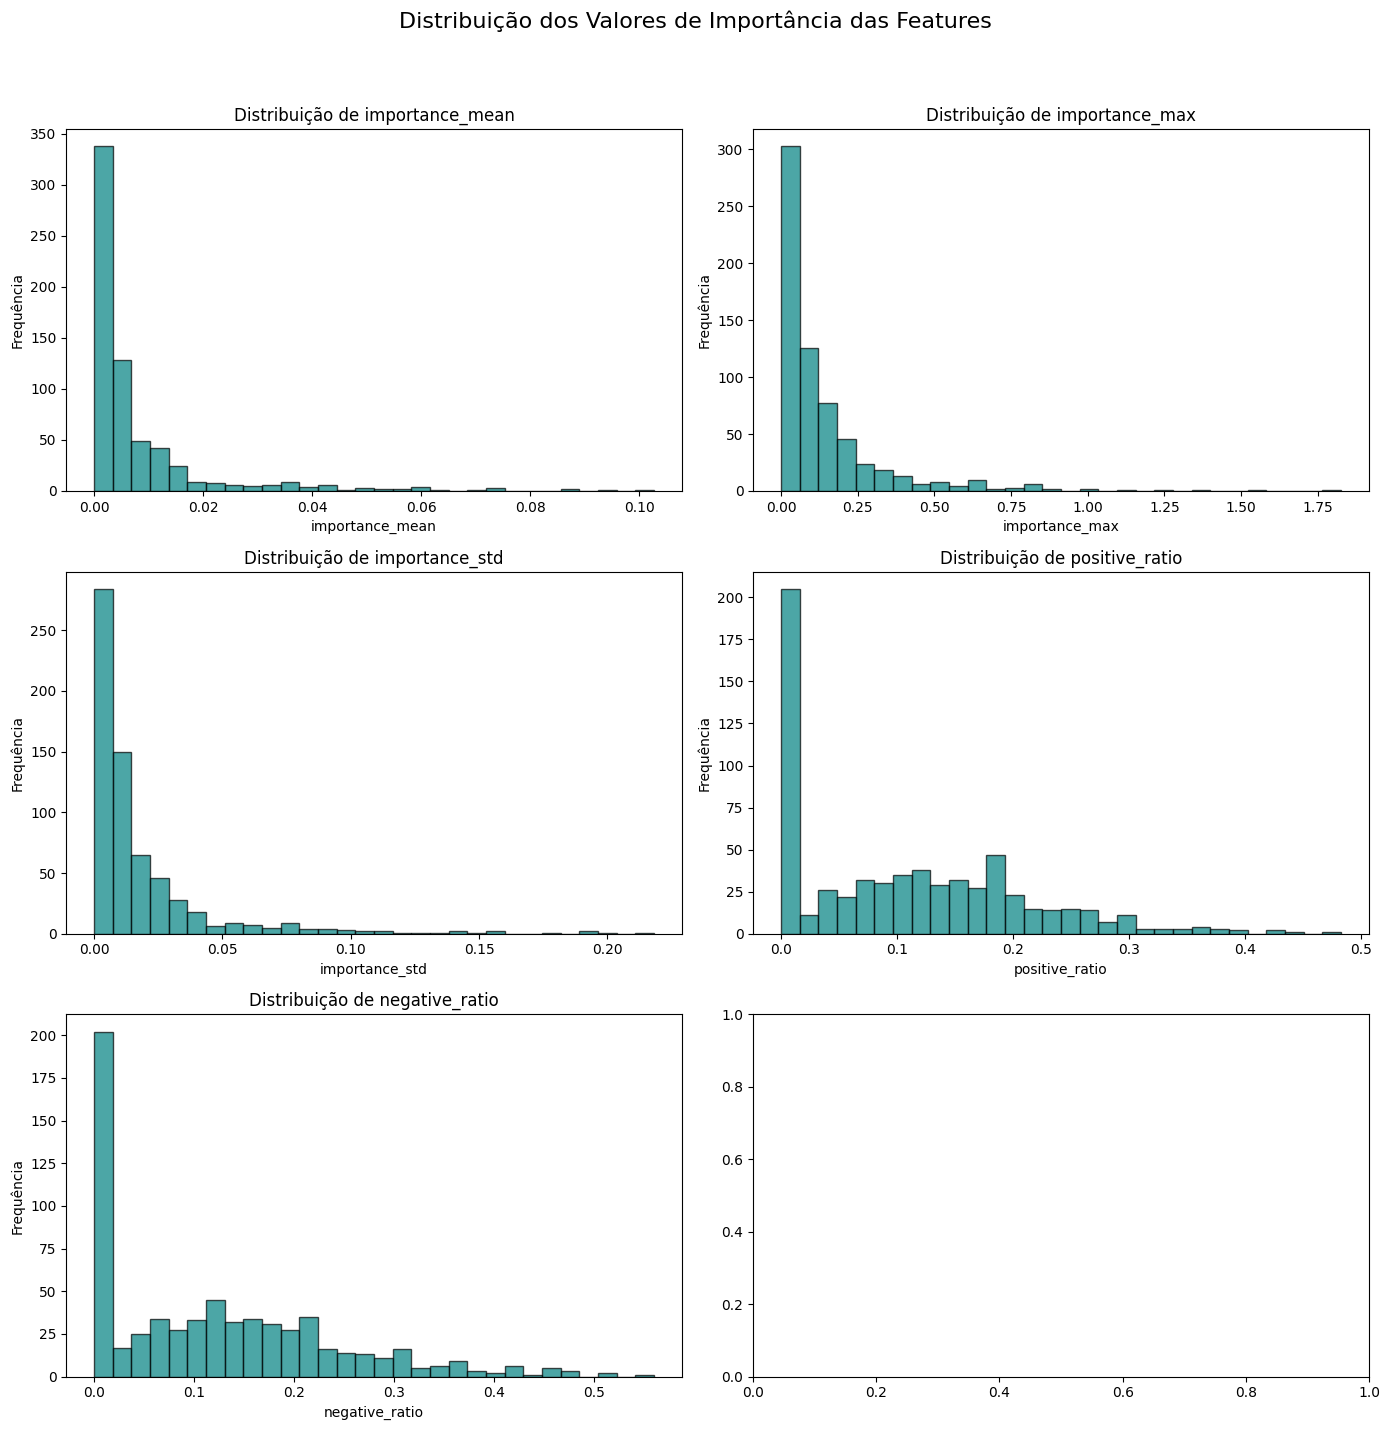

In [113]:
shap_values_df_analysis(shap_importances_xgb)

In [123]:
show_shap_importance_heatmap(shap_importances_xgb,X_shap_init,0)

KeyError: 0

In [ ]:
show_shap_importance_summary_plot(shap_importances_xgb,x_traim,0)

In [99]:
shap_importances_xgb.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,655.000000,655.000000,655.000000,655.000000,655.000000
mean,0.007885,0.136206,0.017982,0.106542,0.120975
std,0.013854,0.207428,0.028987,0.099988,0.117965
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.003219,0.067568,0.009046,0.097541,0.104098
75%,0.008869,0.165089,0.020786,0.177869,0.195902
max,0.102715,1.825959,0.218181,0.482787,0.559836


In [100]:
shap_importances_xgb_0.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness
count,655.000000,655.000000,655.000000,655.000000,655.000000,146.000000
mean,0.008114,0.035725,0.006544,0.098692,0.122519,2.888779
std,0.030074,0.113440,0.020675,0.220326,0.259070,1.980686
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.312767
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.309063
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.514550
75%,0.000000,0.000000,0.000000,0.000000,0.000000,4.107987
max,0.307048,1.250126,0.211041,0.979508,0.979508,7.713615


In [101]:
discard_features_0 = shap_importances_xgb_0[
            (shap_importances_xgb_0["importance_mean"] <= 0.0) |
            (shap_importances_xgb_0["importance_std"] <= 0.01) | 
            (shap_importances_xgb_0["skewness"].abs() > 1) | 
            (shap_importances_xgb_0["negative_ratio"] - shap_importances_xgb_0["positive_ratio"] > 0.7)
        ]["feature"].tolist()

print(len(discard_features_0))

635


In [102]:
shap_importances_xgb_1.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness
count,655.000000,655.000000,655.000000,655.000000,655.000000,176.000000
mean,0.009809,0.039769,0.007229,0.123958,0.140890,2.401322
std,0.035297,0.116558,0.020664,0.233526,0.258271,1.713600
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.332459
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.133700
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.039830
75%,0.005441,0.026359,0.006409,0.131148,0.163934,3.560000
max,0.476448,1.354727,0.246186,0.946721,0.954918,7.319185


In [103]:
discard_features_1 = shap_importances_xgb_1[
            (shap_importances_xgb_1["importance_mean"] <= 0.0) |
            (shap_importances_xgb_1["importance_std"] <= 0.01) | 
            (shap_importances_xgb_1["skewness"].abs() > 1) | 
            (shap_importances_xgb_1["negative_ratio"] - shap_importances_xgb_1["positive_ratio"] > 0.7)
        ]["feature"].tolist()

print(len(discard_features_1))

633


In [104]:
shap_importances_xgb_2.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness
count,655.000000,655.000000,655.000000,655.000000,655.000000,41.000000
mean,0.002390,0.016375,0.002854,0.015242,0.046640,3.710596
std,0.017374,0.103838,0.018752,0.075653,0.188550,2.372950
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.387794
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.075487
50%,0.000000,0.000000,0.000000,0.000000,0.000000,3.479967
75%,0.000000,0.000000,0.000000,0.000000,0.000000,4.708913
max,0.299516,1.825959,0.349474,0.696721,0.987705,9.246768


In [105]:
discard_features_2 = shap_importances_xgb_2[
            (shap_importances_xgb_2["importance_mean"] <= 0.000) |
            (shap_importances_xgb_2["importance_std"] <= 0.00) | 
            (shap_importances_xgb_2["skewness"].abs() > 1) | 
            (shap_importances_xgb_2["negative_ratio"] - shap_importances_xgb_2["positive_ratio"] > 0.7)
        ]["feature"].tolist()

print(len(discard_features_2))

649


In [106]:
shap_importances_xgb_3.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness
count,655.000000,655.000000,655.000000,655.000000,655.000000,191.000000
mean,0.009010,0.037514,0.007130,0.145683,0.145044,2.645884
std,0.029774,0.096223,0.018407,0.258841,0.257391,1.818586
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.858829
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.212048
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.383056
75%,0.005899,0.032463,0.007189,0.227459,0.229508,3.769942
max,0.320307,0.880265,0.171676,0.963115,0.983607,8.760103


In [107]:
discard_features_3 = shap_importances_xgb_3[
            (shap_importances_xgb_3["importance_mean"] <= 0.0) |
            (shap_importances_xgb_3["importance_std"] <= 0.01) | 
            (shap_importances_xgb_3["skewness"].abs() > 1) | 
            (shap_importances_xgb_3["negative_ratio"] - shap_importances_xgb_3["positive_ratio"] > 0.7)
        ]["feature"].tolist()

print(len(discard_features_3))

627


In [108]:
shap_importances_xgb_4.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness
count,655.000000,655.000000,655.000000,655.000000,655.000000,196.000000
mean,0.010102,0.040085,0.007783,0.149137,0.149781,2.466889
std,0.033418,0.113928,0.022902,0.261355,0.262301,1.774683
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.053245
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.022329
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.284341
75%,0.006596,0.031752,0.007773,0.245902,0.237705,3.586357
max,0.376601,1.544241,0.322179,0.963115,0.983607,8.306558


In [109]:
discard_features_4 = shap_importances_xgb_4[
            (shap_importances_xgb_4["importance_mean"] <= 0.0) |
            (shap_importances_xgb_4["importance_std"] <= 0.015) | 
            (shap_importances_xgb_4["skewness"].abs() > 1) | 
            (shap_importances_xgb_4["negative_ratio"] - shap_importances_xgb_4["positive_ratio"] > 0.7)
        ]["feature"].tolist()

print(len(discard_features_4))

634


In [110]:
class_discard_features = []
class_discard_features.append(discard_features_0)
class_discard_features.append(discard_features_1)
class_discard_features.append(discard_features_2)
class_discard_features.append(discard_features_3)
class_discard_features.append(discard_features_4)

feature_counts = {}
for discard_list in class_discard_features:
    for feature in discard_list:
        if feature not in feature_counts:
            feature_counts[feature] = 0
        feature_counts[feature] += 1
    
# Selecionar as features que são descartadas em 3 ou mais classes
combined_classes = [feature for feature, count in feature_counts.items() if count > 4]
print(len(combined_classes))

564


In [111]:
shap_train_df = corr_train_df.drop(columns=combined_classes, errors="ignore")
shap_control_df = corr_control_df.drop(columns=combined_classes, errors="ignore")
shap_test_df = corr_test_df.drop(columns=combined_classes, errors="ignore")

In [112]:
shap_train_df.to_csv("../Dataset/train_radiomics_hipocamp_processed_91_features.csv",index=False)
shap_control_df.to_csv("../Dataset/train_radiomics_occipital_CONTROL_processed_91_features.csv",index=False)
shap_test_df.to_csv("../Dataset/test_radiomics_hipocamp_processed_91_features.csv",index=False)

# Models Tester

In [ ]:
results = {"ANNModel":[None,None]}
test_results = {}

In [ ]:
x_train, x_test, y_train, y_test = define_X_y(shap_train_df,shap_test_df,random_state=42)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

## Basic Models

In [ ]:
rf_model, xgb_model, gradient_model, cat_model, log_model, light_model,svm_model = apply_basic_models(x_train,y_train,x_test,y_test)

In [ ]:
stacking_model = stacking_ensemble(x_train,y_train,rf_model,xgb_model,light_model,svm_model,log_model)
results["StackingBasicLog"] = [stacking_model,None]
models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train)

In [ ]:
stacking_model = stacking_ensemble(x_train,y_train,rf_model,xgb_model,light_model,svm_model,log_model)
f1_macro = final_score(stacking_model, x_test, y_test,plot=1)
test_results[x_train.shape[1]] = f1_macro
plot_final_scores(test_results)

## GridSearch Tuning

In [ ]:
results = {}
svm_grid_model = svm_grid_train_model(x_train,y_train)
results["SVMGrid"] = [svm_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

log_grid_model = log_grid_train_model(x_train,y_train)
results["LogGrid"] = [log_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

rf_grid_model = random_forest_grid_model(x_train,y_train)
results["RandomForestGrid"] = [rf_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoostGrid"] = [xgb_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

light_grid_model = light_grid_train_model(x_train,y_train)
results["lightGrid"] = [light_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

In [ ]:
stacking_grid_model = stacking_ensemble(x_train,y_train,rf_grid_model,xgb_grid_model,light_grid_model,svm_grid_model,log_grid_model)
results["StackingGridLog"] = [stacking_grid_model,None]
models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train)

In [ ]:
stacking_grid_model = stacking_ensemble(x_train,y_train,rf_grid_model,xgb_grid_model,light_grid_model,svm_grid_model,log_grid_model)
models = {"stacking":stacking_grid_model}
final_score(stacking_grid_model, x_test, y_test, models)

In [ ]:
save_stuff(stacking_grid_model,f"Models/stacking_grid_model_results2.pkl")
save_stuff(rf_grid_model,f"Models/rf_grid_model_results2.pkl")
save_stuff(xgb_grid_model,f"Models/xgb_grid_model_results2.pkl")
save_stuff(light_grid_model,f"Models/light_grid_model_results2.pkl")
save_stuff(svm_grid_model,f"Models/svm_grid_model_results2.pkl")
save_stuff(log_grid_model,f"Models/log_grid_model_results2.pkl")

In [ ]:
score_list = []
variance_list = []
bias_list = []

for i in range(10):
    x_train, x_test, y_train, y_test = define_X_y(shap_train_df,random_state=i)
    print(i)
    stacking_grid_model_test = stacking_ensemble(x_train,y_train,rf_grid_model,xgb_grid_model,light_grid_model,svm_grid_model,log_grid_model)
    f1_macros = final_score(stacking_grid_model_test, x_test, y_test,plot=0)
    score_list.append(f1_macros)

print(f"f1: {np.mean(score_list)}") 

# Get Preds

In [ ]:
rf = load_stuff(f"Models/rf_grid_model_results.pkl")
xgboost = load_stuff(f"Models/xgb_grid_model_results.pkl")
light_grid_model = load_stuff(f"Models/light_grid_model_results.pkl")
log = load_stuff(f"Models/log_grid_model_results.pkl")
svm = load_stuff(f"Models/svm_grid_model_results.pkl")
stacking_model = stacking_ensemble(x_train,y_train,rf,xgboost,lightboost,svm,log)

In [ ]:
rf_grid_model = load_stuff("Models/rf_grid_model_results.pkl")
xgb_grid_model = load_stuff("Models/xgb_grid_model_results.pkl")
light_grid_model = load_stuff("Models/light_grid_model_results.pkl")
svm_grid_model = load_stuff("Models/svm_grid_model_results.pkl")
log_grid_model = load_stuff("Models/log_grid_model_results.pkl")

In [ ]:
rf_params = rf_model.get_params()
xgb_params = xgb_model.get_params()
light_params = light_model.get_params()
svm_params = svm_model.get_params()

In [ ]:
rf_grid_params = rf_grid_model.get_params()
xgb_grid_params = xgb_grid_model.get_params()
light_grid_params = light_grid_model.get_params()
svm_grid_params = svm_grid_model.get_params()
log_grid_model = log_grid_model.get_params()

In [ ]:
rf_preds_model = RandomForestClassifier(**rf_grid_params)
xgb_preds_model = XGBClassifier(**xgb_grid_params)
light_preds_model = lgb.LGBMClassifier(**light_grid_params)
svm_preds_model = SVC(**svm_grid_params)
log_grid_model = LogisticRegression(**log_grid_model)


In [ ]:
score_list = []
variance_list = []
bias_list = []

for i in range(10):
    x_train, x_test, y_train, y_test = define_X_y(shap_train_df,random_state=i)
    print(i)
    stacking_grid_model_test = stacking_ensemble(x_train,y_train,rf_preds_model,xgb_preds_model,light_preds_model,svm_preds_model,log_grid_model)
    f1_macros = final_score(stacking_grid_model_test, x_test, y_test,plot=0)
    score_list.append(f1_macros)

print(f"f1: {np.mean(score_list)}") 

In [ ]:
stacking_model_log = stacking_ensemble(x_train,y_train,rf_preds_model,xgb_preds_model,light_preds_model,svm_preds_model,log_grid_model)

## Preds to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [ ]:
preds_to_csv(stacking_model.predict(x_test))

In [ ]:
save_stuff(stacking_model_log,"Models/stacking_reduction_dos_shap_globais_thre_0_02.pkl")

In [ ]:
stacking_model_log